In [ ]:
 !pip -q install pandas openpyxl networkx scikit-learn
 !pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
 !pip -q install torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.4.0+cpu.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.5/543.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.6/792.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [ ]:
import pandas as pd
import io, os

SHEET_NAME = "australia_insurance_extended_mo"

file_path = "/content/synthetic_insurance_50k.csv"
df = pd.read_csv(file_path)
print("Rows:", len(df), "| Columns:", list(df.columns))
df.head()


Rows: 50000 | Columns: ['Age', 'State', 'Insurance Type', 'Annual Premium (AUD)', 'Claim Amount (AUD)', 'Claim Status', 'Policy Start Date', 'Policy End Date', 'Product Tier', 'Payment Frequency', 'Risk Score']


,Age,State,Insurance Type,Annual Premium (AUD),Claim Amount (AUD),Claim Status,Policy Start Date,Policy End Date,Product Tier,Payment Frequency,Risk Score
0,54,VIC,Life,3226.72,8762.05,Approved,21-02-2023,21-02-2024,Premium,Annually,0.72
1,38,TAS,Health,4255.91,5699.27,Approved,10-07-2023,09-07-2024,Premium,Annually,0.49
2,56,QLD,Health,6318.77,12724.00,Approved,23-09-2023,22-09-2024,Premium,Annually,0.75
3,78,ACT,Car,3404.39,6785.40,Approved,12-08-2024,12-08-2025,Gold,Annually,0.81
4,23,NSW,Life,1816.43,602.24,Approved,30-06-2023,29-06-2024,Basic,Monthly,0.22


In [ ]:
# Step 2: Identify Column Types
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("\nCategorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)


Categorical Columns: ['State', 'Insurance Type', 'Claim Status', 'Policy Start Date', 'Policy End Date', 'Product Tier', 'Payment Frequency']
Numerical Columns: ['Age', 'Annual Premium (AUD)', 'Claim Amount (AUD)', 'Risk Score']


In [ ]:
# Step 3: Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

In [ ]:
# Step 4: Clustering Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=2, random_state=42)),   # 2D for visualization
    ("cluster", KMeans(n_clusters=5, random_state=42, n_init=10))
])

# Fit pipeline
cluster_labels = pipeline.fit_predict(df)

# Add cluster labels to dataframe
df["Cluster"] = cluster_labels

In [ ]:
# Step 5: Cluster Evaluation
sil_score = silhouette_score(
    pipeline.named_steps["pca"].transform(
        pipeline.named_steps["preprocessor"].transform(df.drop(columns="Cluster"))
    ),
    cluster_labels
)

print("\nCluster Counts:\n", df["Cluster"].value_counts())
print("Silhouette Score:", sil_score)


Cluster Counts:
 Cluster
0    13843
4    11151
2     9390
3     9150
1     6466
Name: count, dtype: int64
Silhouette Score: 0.4024851134923543


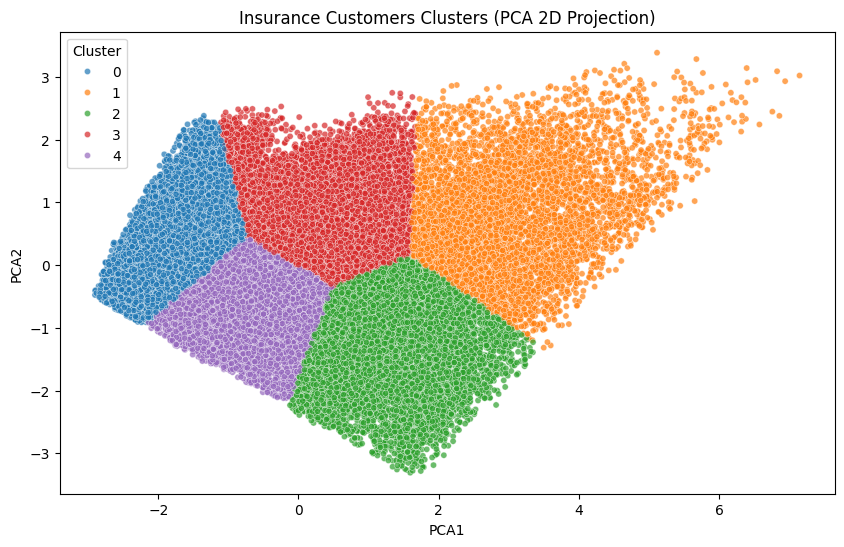

In [ ]:
# Step 6: Visualization
pca_features = pipeline.named_steps["pca"].transform(
    pipeline.named_steps["preprocessor"].transform(df.drop(columns="Cluster"))
)

df["PCA1"] = pca_features[:, 0]
df["PCA2"] = pca_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", palette="tab10", data=df, s=20, alpha=0.7)
plt.title("Insurance Customers Clusters (PCA 2D Projection)")
plt.show()

In [ ]:
cluster_summary = df.groupby("Cluster")[numerical_cols].mean()
print("\nCluster Summary (Numerical Features):\n", cluster_summary.head())


Cluster Summary (Numerical Features):
                Age  Annual Premium (AUD)  Claim Amount (AUD)  Risk Score
Cluster                                                                 
0        25.443907           2343.857234         1389.581117    0.205616
1        62.535261           5233.203107        11771.022164    0.698698
2        62.195634           2192.312749         4097.527886    0.686264
3        37.757705           4143.476080         5491.888776    0.442208
4        37.627477           1621.024709         2052.388701    0.451851


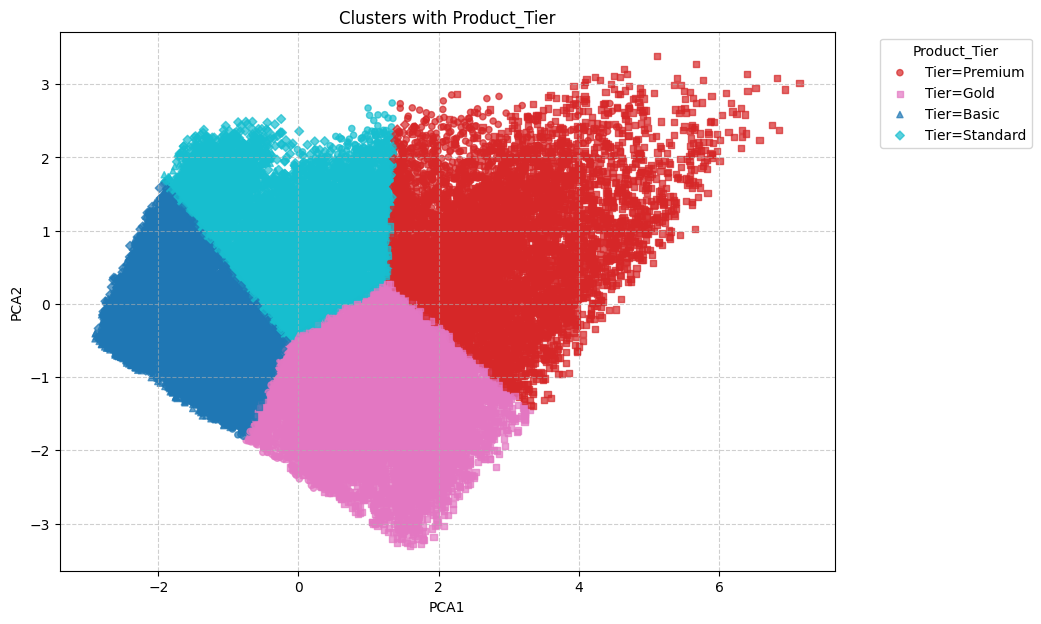

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Already have df["Cluster"], df["PCA1"], df["PCA2"], and df["Product_Tier"]

plt.figure(figsize=(10,7))
markers = ["o", "s", "^", "D", "P", "*", "X", "<", ">"]
tiers = df["Product Tier"].unique()

for i, tier in enumerate(tiers):
    subset = df[df["Product Tier"] == tier]
    plt.scatter(subset["PCA1"], subset["PCA2"],
                c=subset["Cluster"], cmap="tab10",
                marker=markers[i % len(markers)], s=20, alpha=0.7,
                label=f"Tier={tier}")

plt.title("Clusters with Product_Tier")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Product_Tier", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()